<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/DeepLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Semantic Segmentatio (DeepLab)

# Libraries Import

In [1]:
import os
import tarfile                   
import tempfile                  
from six.moves import urllib     
from io import BytesIO           

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import cv2 
import IPython
from PIL import Image
from tqdm import tqdm
from tabulate import tabulate 
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print(tf.__version__)

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.8.2


# Neural Networking Building

In this example, we are using the model checkpoint that was trained on the [Cityscapes dataset](https://www.cityscapes-dataset.com/).

In [4]:
class DeepLabModel(object):
    """Class to load the deeplab model and do the inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """ Create and load the pre-training deeplab template. """
        self.graph = tf.Graph()
        graph_def = None

        # Extract the frozen graph from the tar file.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Could not find inference graph in tar file.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Run the inference on an image.

         Params:
             image: PIL.Image object that contains the input image.
             INPUT_TENSOR_NAME: The name of the input tensor. pattern=ImageTensor
             OUTPUT_TENSOR_NAME: The name of the output tensor. default=SemanticPredictions

         Returns:
             resized_image: resized RGB input image
             seg_map: `resized_image` segmentation map
        """
        width, height = image.size
        target_size = (2049,1025)  # Cityscapes dataset images size
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)

        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        
        seg_map = batch_seg_map[0]  # wait the batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # adds an extra dimension needed by cv2.resize

        seg_map = cv2.resize(seg_map, (width,height), interpolation=cv2.INTER_NEAREST)
        return seg_map

# Visualation Functions


In [3]:
def create_colormap():
    """
    Retorn:
        Numpy array with colormap to visualize segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [120, 155,  42],
        [152, 251, 152],
        [ 93, 165, 227],
        [220,  20,  60],
        [255,   0,   0],
        [ 34,  34, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap

In [5]:
def label_to_color_image(label):
    """
    Params:
         label: 2D array that stores the segmentation label.

     Returns:
         segmentation map: 2D array with float values. The array element is the color indexed by the corresponding element in the input label.
         That is, it will return an image that corresponds to the original, but it will paint the pixels with what the algorithm predicted.
    """
    
    # returns error if input label does not have 2 dimensions
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_colormap()

    # returns error if the value/index of the label is greater than the maximum index value allowed for the color list.
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [6]:
def segmentation_vis(image, seg_map):
  
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.figure(figsize=(20, 4))
    # create subplots in grid format
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    # subplot to show the raw image (input image)
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('Raw Image')

    # subplot to show the segmentation map
    plt.subplot(grid_spec[1])
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('Segmentation Map')

    # subplot to show the segmentation overlay 
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('Segmentation overlay') 

    # subplot to show the labels, in the form of legends (color and name side by side)
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

    # saves the image overlay in a variable, which will be returned by the function (so we can later save the image to a file)
    result_image = cv2.addWeighted(np.uint8(image), 0.3, np.uint8(seg_image), 0.7, 0)

    return result_image

In [7]:
LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

len(LABEL_NAMES)

20

In [8]:
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1) # classes IDs
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)                     # colors associated with IDs

print(FULL_LABEL_MAP, FULL_COLOR_MAP)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]] [[[128  64 128]]

 [[244  35 232]]

 [[ 70  70  70]]

 [[102 102 156]]

 [[190 153 153]]

 [[153 153 153]]

 [[250 170  30]]

 [[220 220   0]]

 [[120 155  42]]

 [[152 251 152]]

 [[ 93 165 227]]

 [[220  20  60]]

 [[255   0   0]]

 [[ 34  34 142]]

 [[  0   0  70]]

 [[  0  60 100]]

 [[  0  80 100]]

 [[  0   0 230]]

 [[119  11  32]]

 [[  0   0   0]]]


# Neural Network Loading

There are two pre-trained models (*frozen graph*) that we can use, with two distinct backbones: MobileNetV2 and Xception65. 
* **MobileNetV2** - allows you to make inference quickly, so it will process image/video in less time. Its MobileNet backbone was designed to run faster on mobile devices or devices that don't have such powerful hardware.

* **Xception65** - is more computationally expensive compared to MobileNet, but offers more accurate results and consequently a segmentation closer to the real thing.

For this dataset that we will see shortly, MobileNetV2 generally obtained good results and often even better, but in other types of images it is likely that Xception65 guarantees more robust results in general..

In [9]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

In [10]:
DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine' : 'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine'       : 'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}

In [11]:
TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

In [12]:
download_path = os.path.join(model_dir, TARBALL_NAME)
download_path

'/tmp/tmpkfj82sp2/deeplab_model.tar.gz'

In [13]:
urllib.request.urlretrieve(DOWNLOAD_URL_PREFIX + MODEL_URLS[MODEL_NAME], download_path)

('/tmp/tmpkfj82sp2/deeplab_model.tar.gz',
 <http.client.HTTPMessage at 0x7f90736707d0>)

In [14]:
model = DeepLabModel(download_path)

# Image Segmentation

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
!cp /content/gdrive/MyDrive/image-segmentation-course/fotos/driveseg_amostra.jpg /content/driveseg_amostra.jpg

In [17]:
test_img = '/content/driveseg_amostra.jpg'

In [18]:
def run_segmentation(path):
  raw_img = Image.open(path)
  seg_map = model.run(raw_img)
  processed_img = segmentation_vis(raw_img, seg_map)
  return processed_img

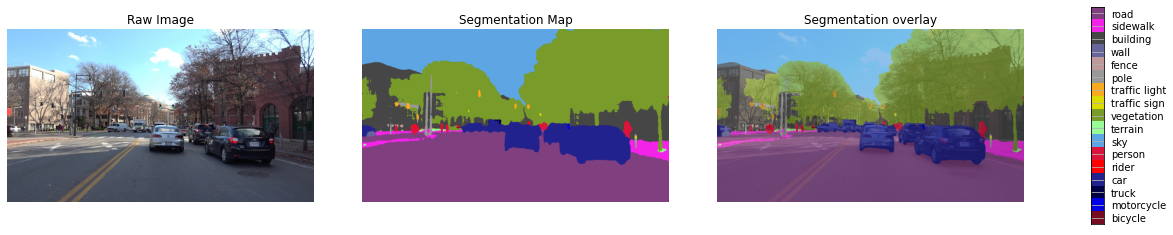

In [19]:
processed_img = run_segmentation(test_img)

# Video Segmentation

In [20]:
def video_segmentation_vis(image, seg_map, index):
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('Segmentation | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Shows the results in real time, as each frame of the video is played (as if it were a real streaming)
    filee = BytesIO()
    plt.savefig(filee, format='jpeg')
    IPython.display.display(IPython.display.Image(data=filee.getvalue()))
    filee.close()
    plt.close()

    result_img = cv2.addWeighted(np.uint8(image), 0.3, np.uint8(seg_image), 0.7, 0)
    return result_img

In [21]:
def run_video_segmentation(frame, index):
    raw_img = Image.fromarray(frame[..., ::-1])
    seg_map = model.run(raw_img)
    processed_frame = video_segmentation_vis(raw_img, seg_map, index)
    processed_img = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)
    return processed_img 

In [22]:
!wget https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4

--2022-07-18 23:15:54--  https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lexfridman/mit-deep-learning/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4 [following]
--2022-07-18 23:15:54--  https://raw.githubusercontent.com/lexfridman/mit-deep-learning/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28576737 (27M) [application/octet-stream]
Saving to: ‘mit_driveseg_sample.mp4’

mit_driveseg_sa

In [23]:
def video_settings(video_widht, video_heigth, file_name='result.avi'): 
  fourcc = cv2.VideoWriter_fourcc(*'XVID') 
  fps = 24
  video_output = cv2.VideoWriter(file_name, fourcc, fps, (video_widht, video_heigth))
  return video_output 

In [24]:
test_video = 'mit_driveseg_sample.mp4'

cap = cv2.VideoCapture(test_video)
num_frames = 150  # 598 is the total number of frames
initial_frame = 0
current_frame = 0 # auxiliary variable used for the for loop further down

connected, video = cap.read()
video_widht, video_heigth = video.shape[1], video.shape[0]
video_output = video_settings(video_widht, video_heigth)

try:
    for idx in range(num_frames):
      _, frame = cap.read()
      if not _: break

      if idx < initial_frame:
        continue
      frame_processado = run_video_segmentation(frame, idx)
      IPython.display.clear_output(wait=True)
      current_frame = current_frame + 1
      # save processed frame in final video file
      video_output.write(frame_processado) 

except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


print("Done")
video_output.release() 

Done


In [25]:
!ffmpeg -y -loglevel panic -i result.avi driveseg_result.mp4

In [26]:
def show_video(file_name, widht=720, heigth=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="Video teste" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(widht, heigth, video_encoded.decode('ascii')))

In [27]:
show_video('driveseg_result.mp4')

# Evaluation

- The code for reading and testing with the DriveSeg dataset was based on the code from [lexfridman](https://github.com/lexfridman/mit-deep-learning) from [MIT Deep Learning](https://deeplearning.mit .edu).

In [28]:
gt_sample = 'mit_driveseg_sample_gt.tar.gz'
gt_sample = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

In [29]:
class DriveSeg(object):

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        """Access ground truth through the given index.

         Param:
             index: The frame number.

         Returns:
             gt: The ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]               # exclui o indice 0, que é o diretorio ascendente 
        file_handle = self.tar_file.extractfile(tar_info) # extrai os arquivos
        gt = np.fromstring(file_handle.read(), np.uint8)  # para ler o ground truth no formato correto 
        gt = cv2.imdecode(gt, cv2.IMREAD_COLOR)           # lê dados da memória cache e converte (decodifica) em um formato de imagem, para podermos fazer os processamentos
        gt = gt[:, :, 0]                                  # seleciona um unico canal dos 3 canis de cor da imagem 
        gt[gt==255] = 19                                  # classe vazia (void), não conta para precisão 
        return gt 

dataset = DriveSeg(gt_sample) # load the DriveSeg dataset

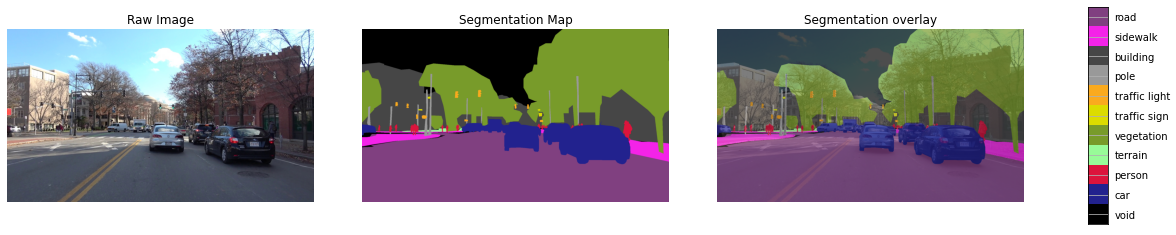

In [30]:
raw_img = Image.open(test_img)
gt = dataset.fetch(126)  # frame 126
img = segmentation_vis(raw_img, gt)

In [31]:
LABEL_NAMES

array(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle', 'void'], dtype='<U13')

In [32]:
def evaluate_image(seg_map, ground_truth):
  seg_map[np.logical_or(seg_map == 14, seg_map == 15)] = 13
  seg_map[np.logical_or(seg_map == 3, seg_map == 4)] = 2
  seg_map[seg_map == 12] = 11

  acc = np.sum(seg_map[ground_truth != 19] == ground_truth[ground_truth != 19]) / np.sum(ground_truth != 19)
  cm = confusion_matrix(ground_truth[ground_truth != 19], seg_map[ground_truth != 19], labels = np.array([0,1,2,5,6,7,8,9,11,13]))

  intersection = np.diag(cm)

  union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)

  return acc, intersection, union

In [33]:
raw_img = Image.open(test_img)
seg_map = model.run(raw_img)
gt = dataset.fetch(126)

acc, intersection, union = evaluate_image(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('Pixel accuracy: ', acc)
print('IoU Avg. for Classes: ', np.mean(class_iou))
print('IoU Classes:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

Pixel accuracy:  0.9078729153719111
IoU Avg. for Classes:  0.554412
IoU Classes:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person      car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  -------
0.96885     0.55714     0.57619  0.31274          0.41071         0.15857       0.82978    0.20237   0.57699  0.95078


In [34]:
test_video = 'mit_driveseg_sample.mp4'
video = cv2.VideoCapture(test_video)
num_frames = 50

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()                                    
    raw_img = Image.fromarray(frame[..., ::-1])           
    seg_map = model.run(raw_img)                          
    gt = dataset.fetch(i)                                      
    _acc, _intersection, _union = evaluate_image(seg_map, gt)  
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('\nPixel accuracy: %.4f'%np.mean(acc))
print('IoU Avg. for Classes: %.4f'%np.mean(class_iou))
print('IoU Classes:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Pixel accuracy: 0.9044
IoU Avg. for Classes: 0.5390
IoU Classes:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9603      0.4725      0.5428  0.2055           0.4465          0.5385        0.8395      0.043    0.3828  0.9584
